In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast


In [2]:
# ========== GOOGLE SENTIMENT vs DICTIONARY  =================
#
# EXPERIMENT WITH TIMESTEP 1H
#
# Predict if the volume is higher respect to 
#

newsGoogle =  pd.read_csv('/home/simone/Desktop/NLFF/GoogleNL/Aggregated_1h_dataset/AAPL_googleSentPerTimestep.csv')
newsDict =  pd.read_csv('/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/AAPL.csv')

price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexesAAPL.csv')

price = price.rename(index=str, columns={"date": "DATE"})

newsGoogle = newsGoogle.rename(index=str, columns={"initTime": "DATE"})
newsDict = newsDict.rename(index=str, columns={"initTime": "DATE"})


newsGoogle['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsGoogle['DATE']]
newsDict['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsDict['DATE']]


# This datased is already GMT+0
price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
newsGoogle['entSentVec'] = [ast.literal_eval(row) for row in newsGoogle['entSentVec']]

#ALLIGNMENT GOOGLE SENTIMENT
initDate = newsGoogle['DATE'][0]
finalDate = newsGoogle['DATE'][len(newsGoogle)-1]
price.drop(price[price.DATE > finalDate].index, inplace=True)
price.drop(price[price.DATE < initDate].index, inplace=True)
price = price.reset_index(drop=True)

for data in newsGoogle['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsGoogle)

#ALLIGNMENT DICT SENTIMENT
newsDict.drop(newsDict[newsDict.DATE > finalDate].index, inplace=True)
newsDict.drop(newsDict[newsDict.DATE < initDate].index, inplace=True)
newsDict = newsDict.reset_index(drop=True)

for data in newsDict['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsDict)


# FEATURES GOOGLE
sentiment = np.asarray(newsGoogle['entSentVec'].tolist())
sentiment = pd.DataFrame(data=sentiment)
X_google = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
X_google = pd.concat([X_google, sentiment.rolling(10).mean()],axis=1)
X_google = pd.concat([X_google, sentiment.rolling(15).mean()],axis=1)
X_google = pd.concat([X_google, sentiment.rolling(20).mean()],axis=1)

# FEATURES DICT
sentiment = newsDict.drop(['Unnamed: 0', 'DATE'], axis=1)
X_dict = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
X_dict = pd.concat([X_dict, sentiment.rolling(10).mean()],axis=1)
X_dict = pd.concat([X_dict, sentiment.rolling(15).mean()],axis=1)
X_dict = pd.concat([X_dict, sentiment.rolling(20).mean()],axis=1)

X_dict.head()


TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]



-48 0 ....................

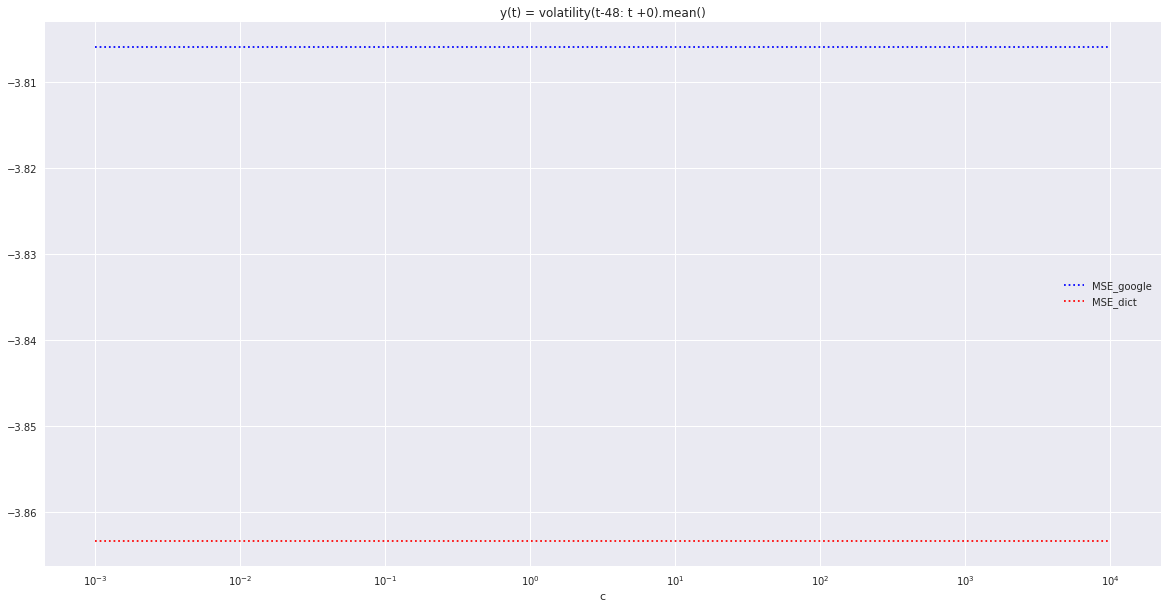


-35 0 ....................

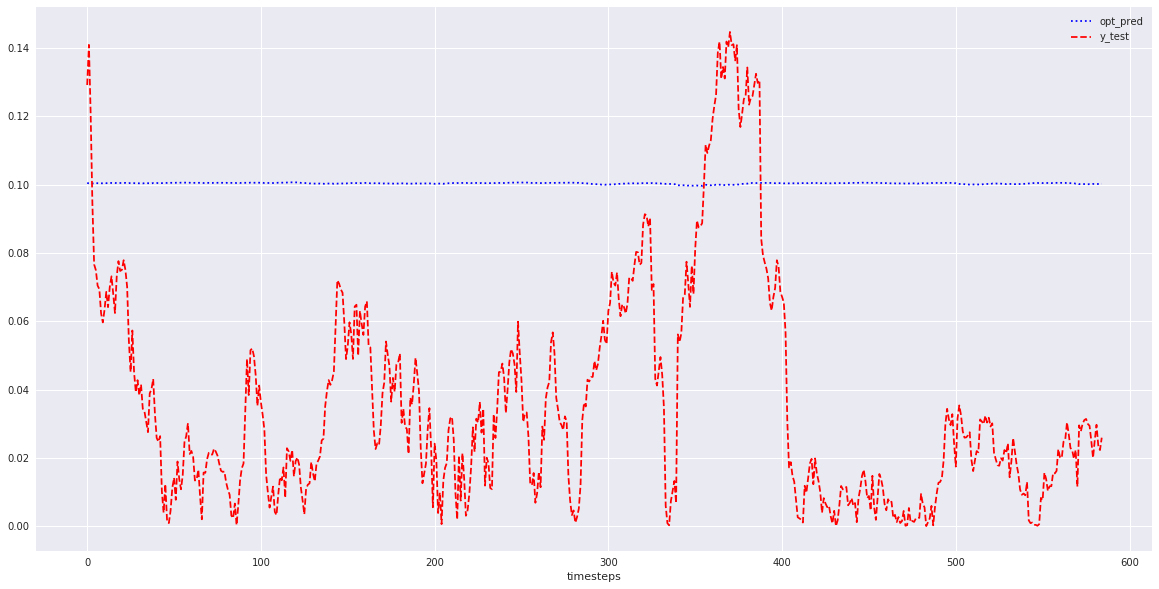

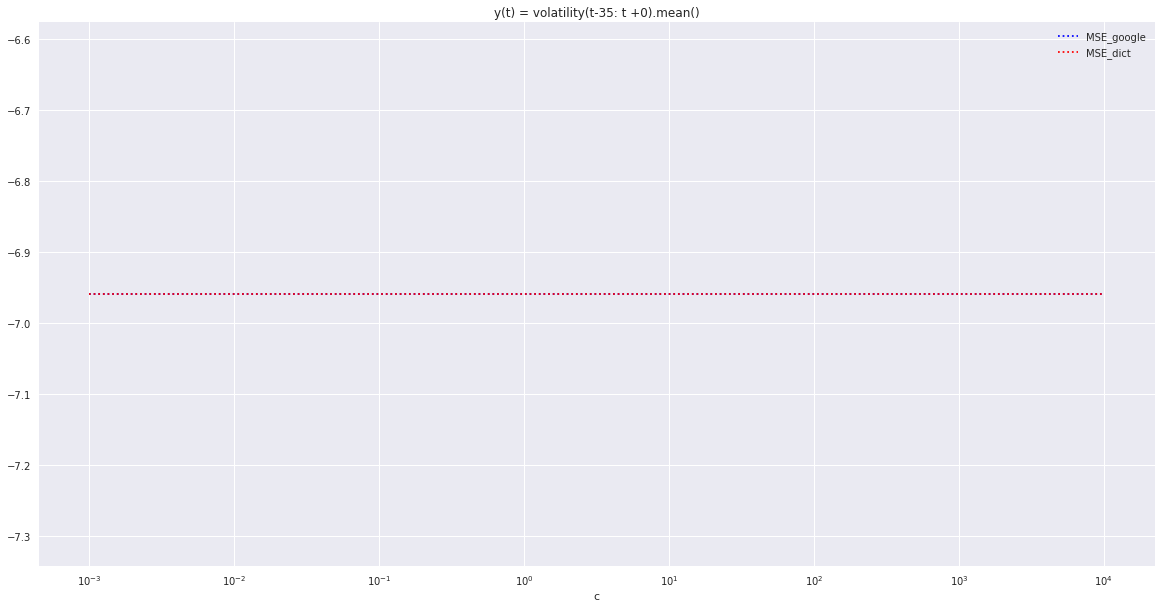


-28 0 ....................

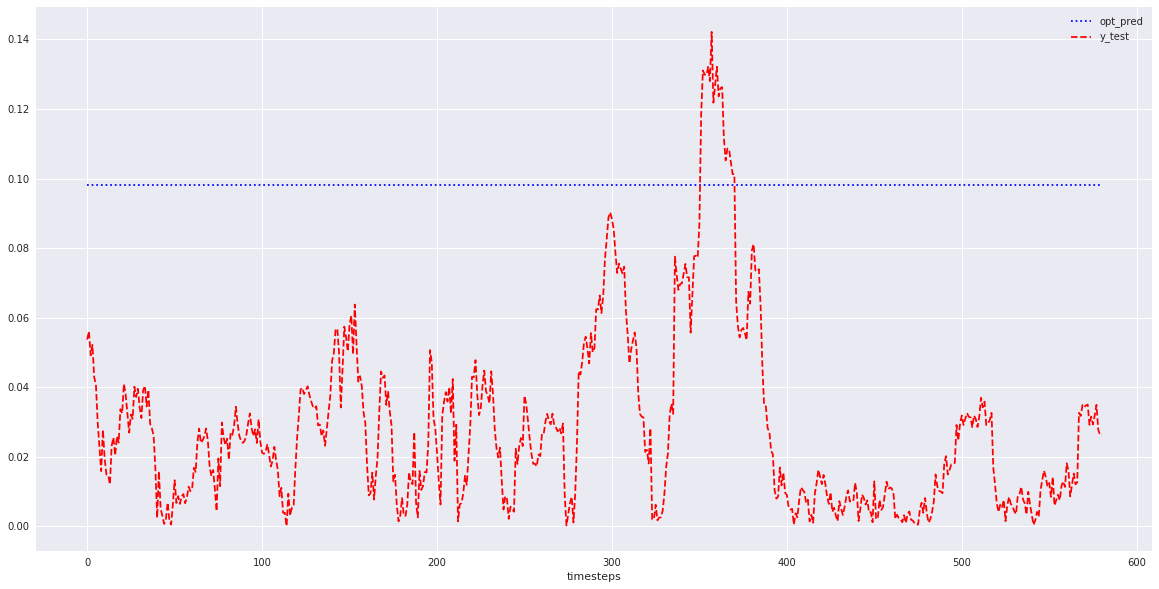

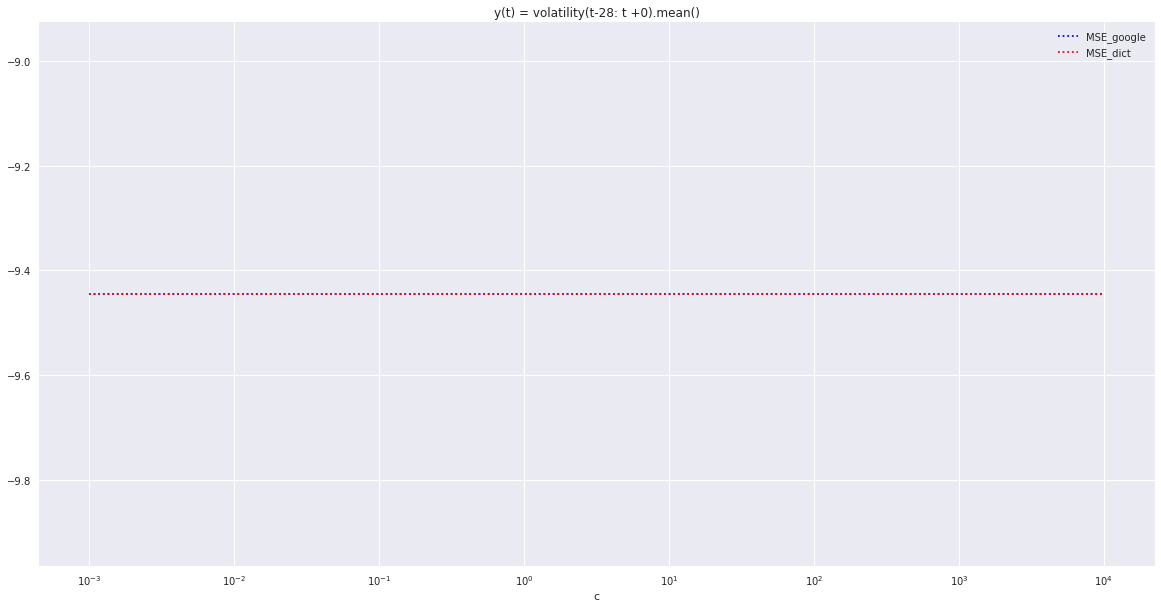


-7 0 ....................

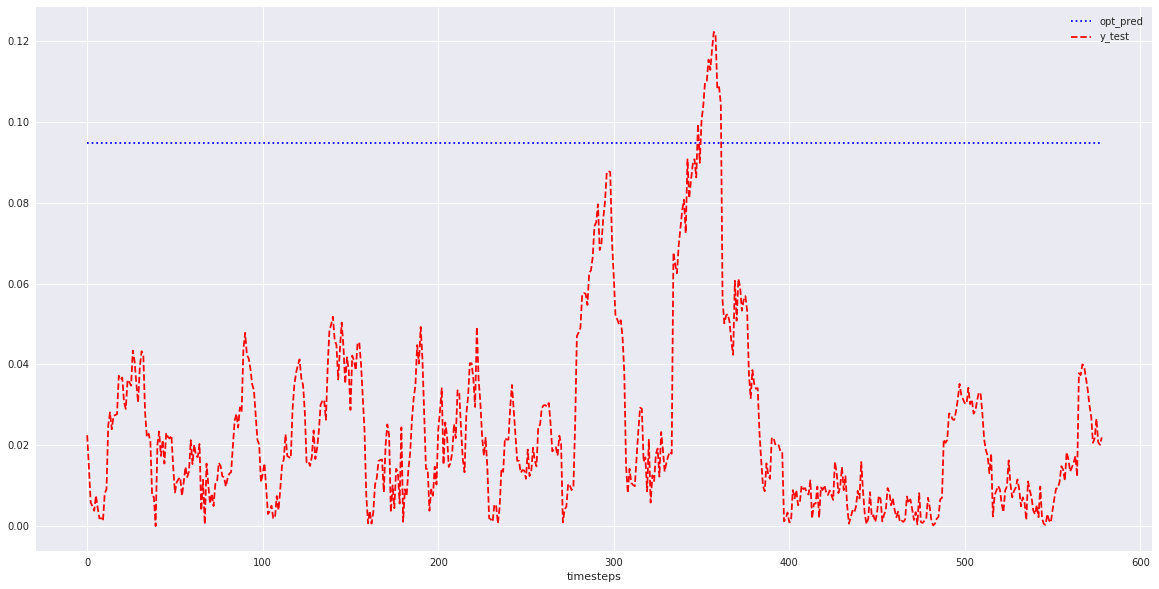

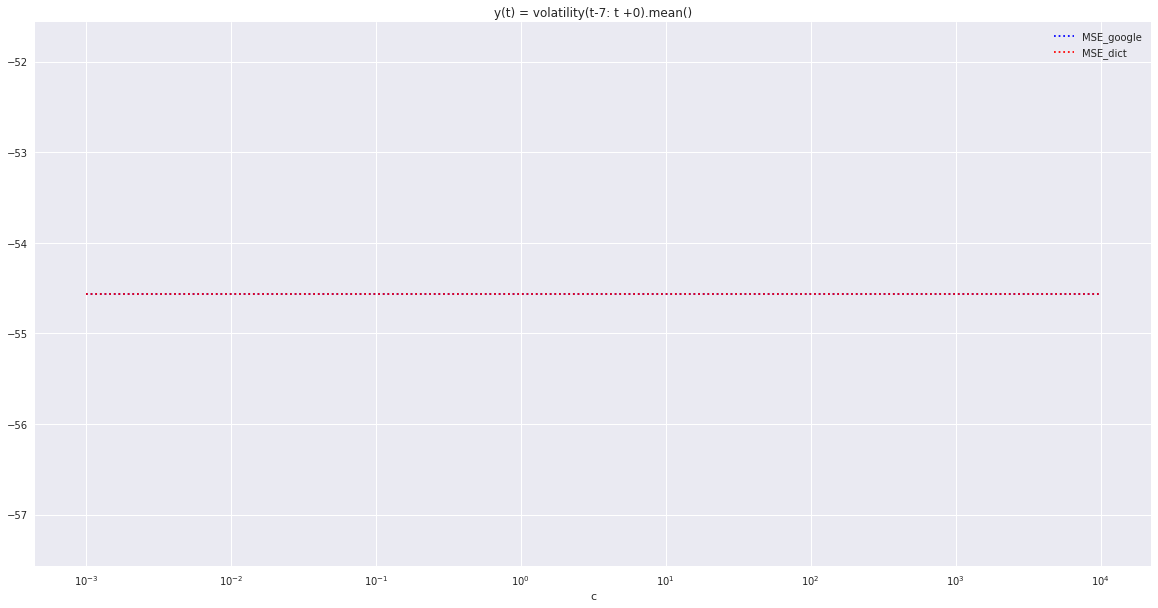


-1 0 ....................

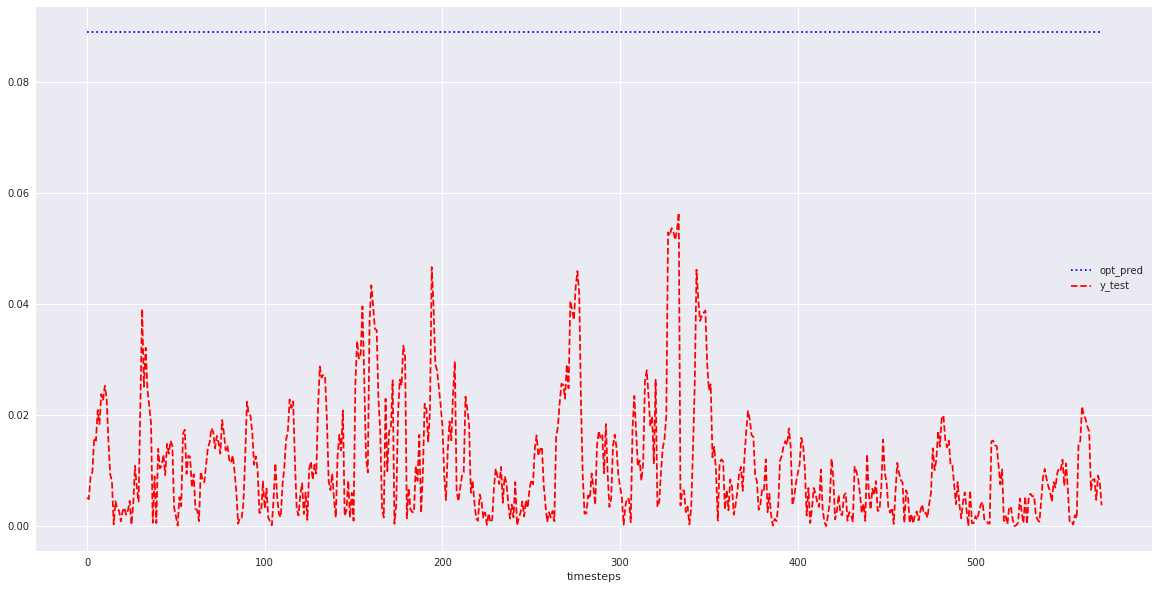

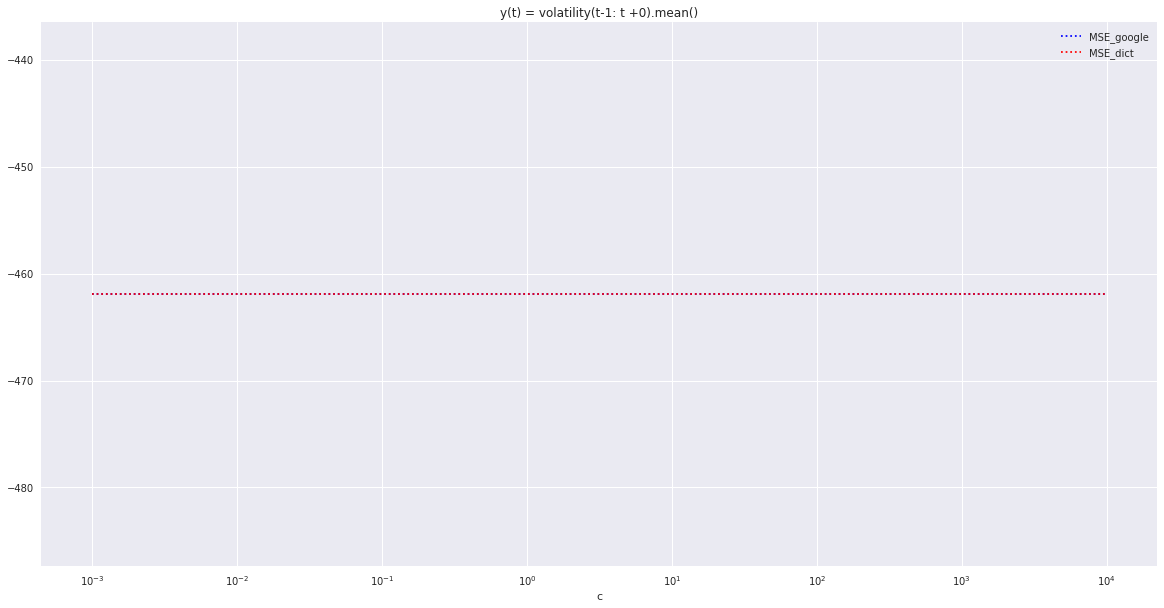


1 2 ....................

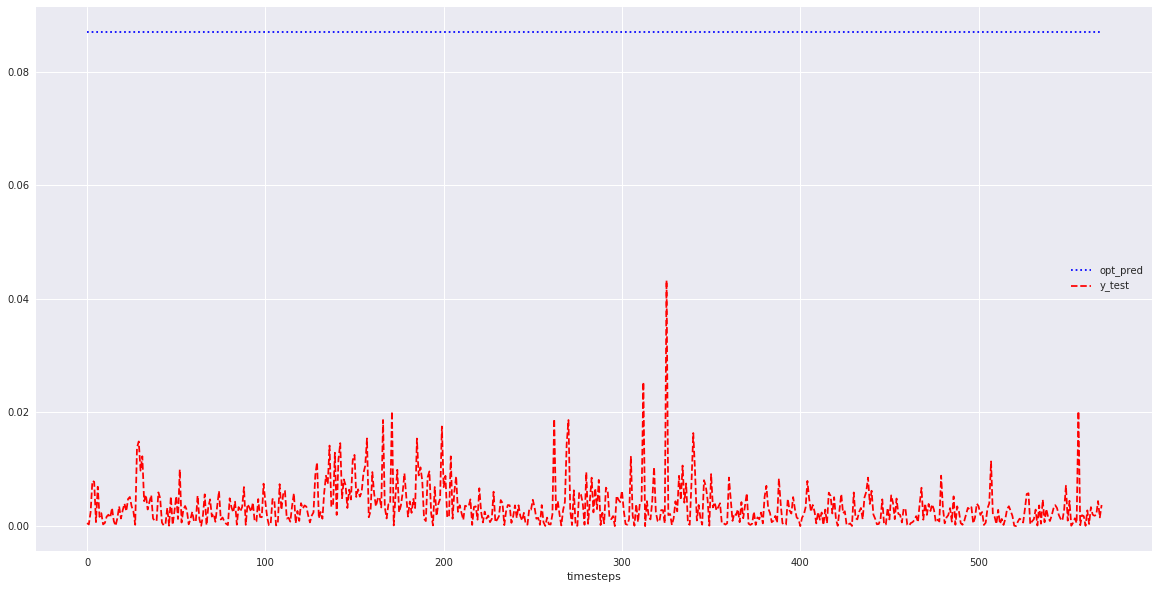

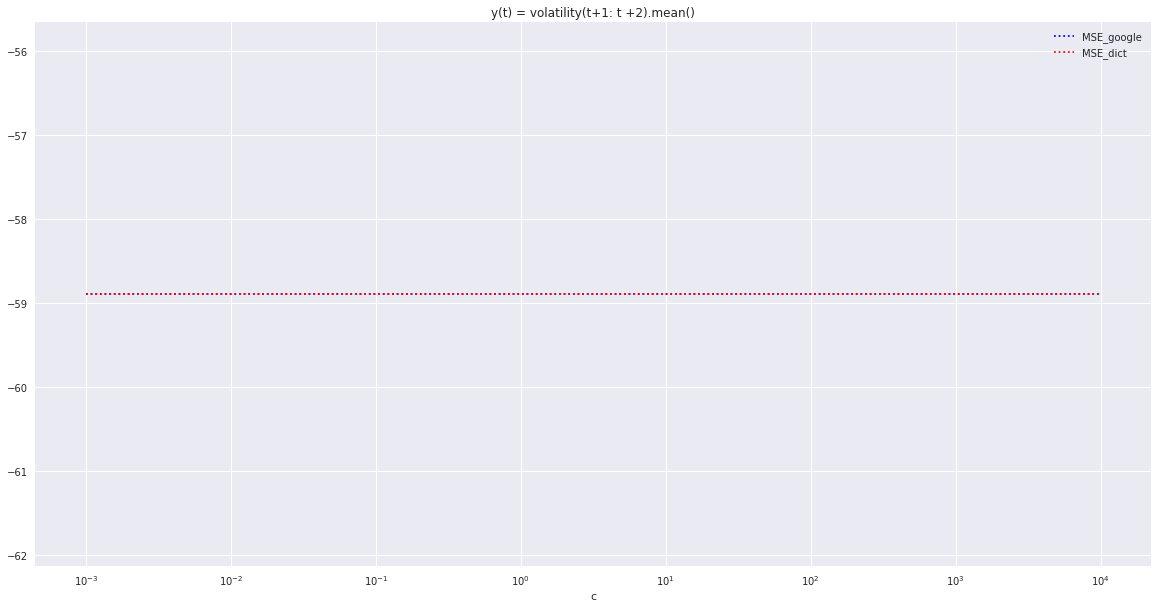


1 8 ....................

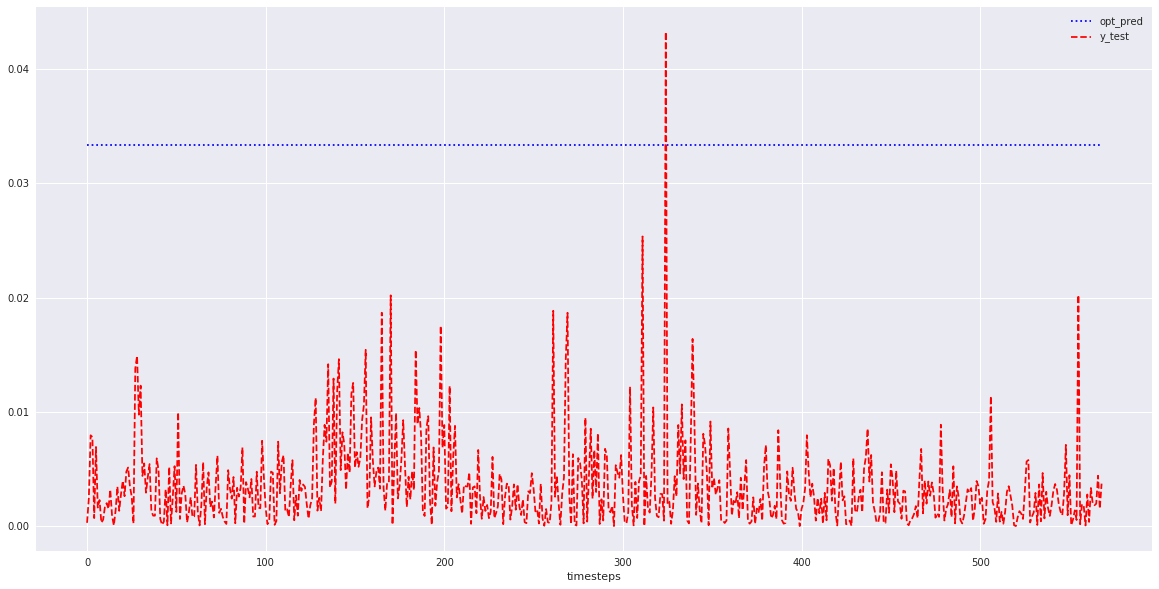

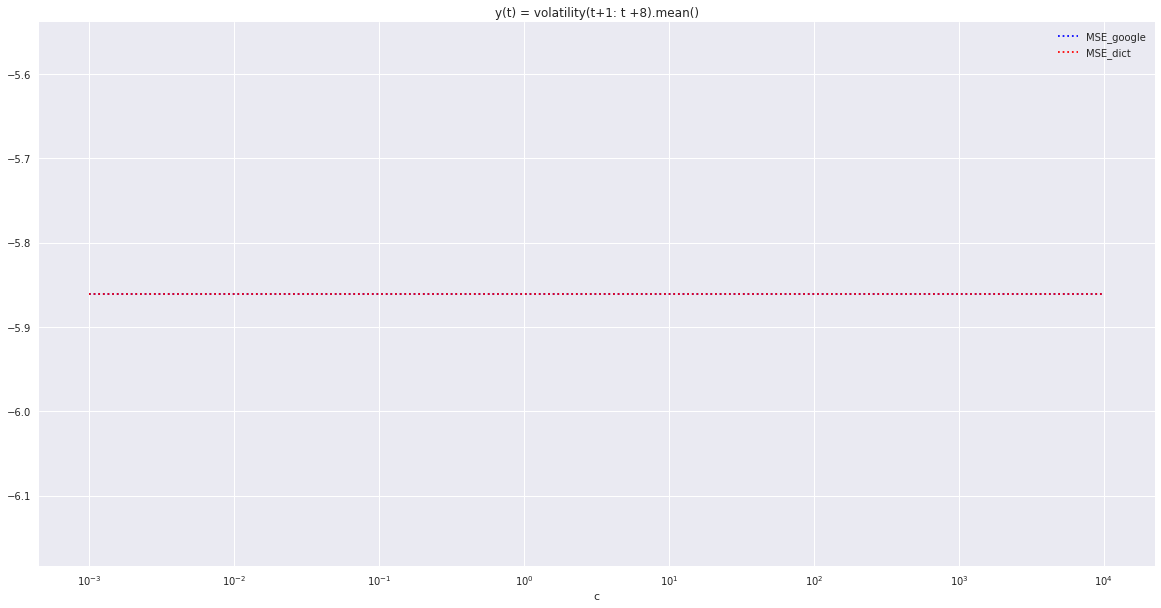


1 29 ....................

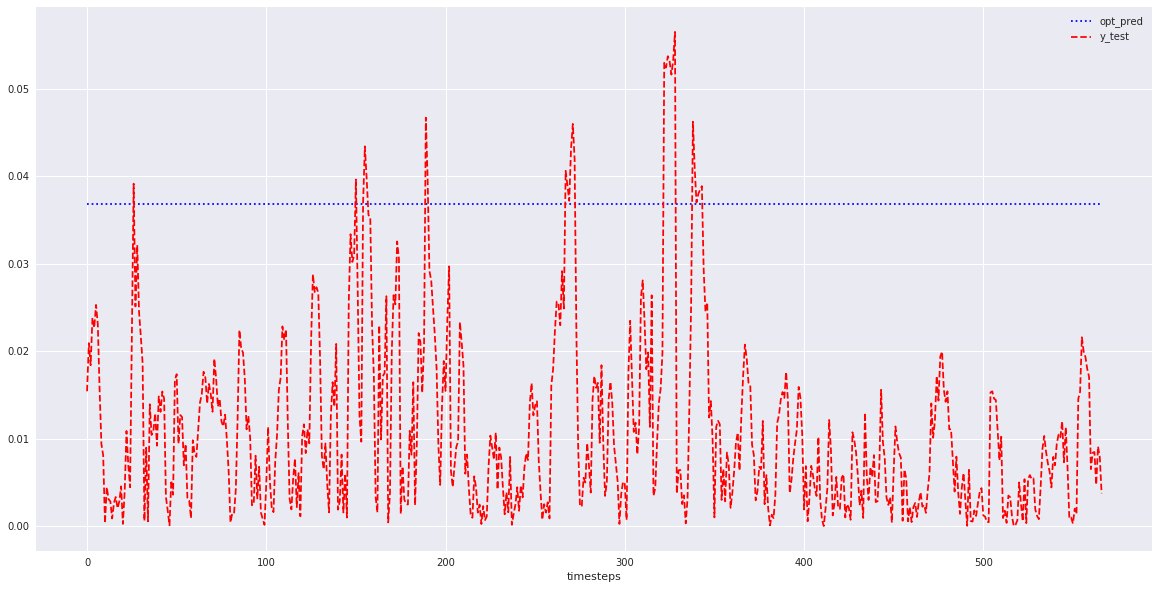

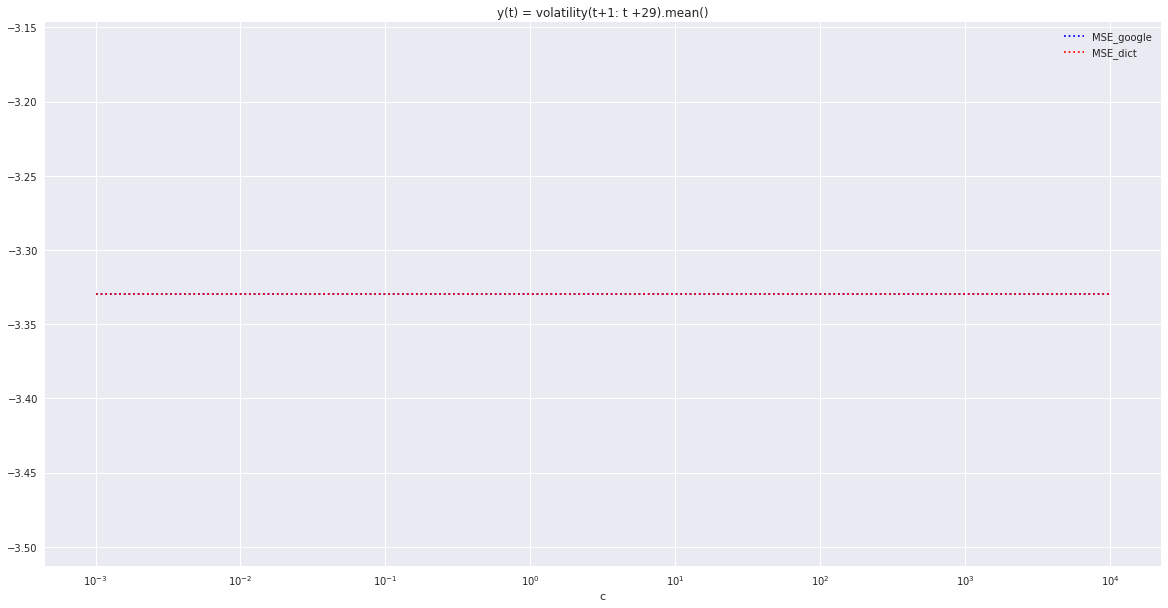


1 36 ....................

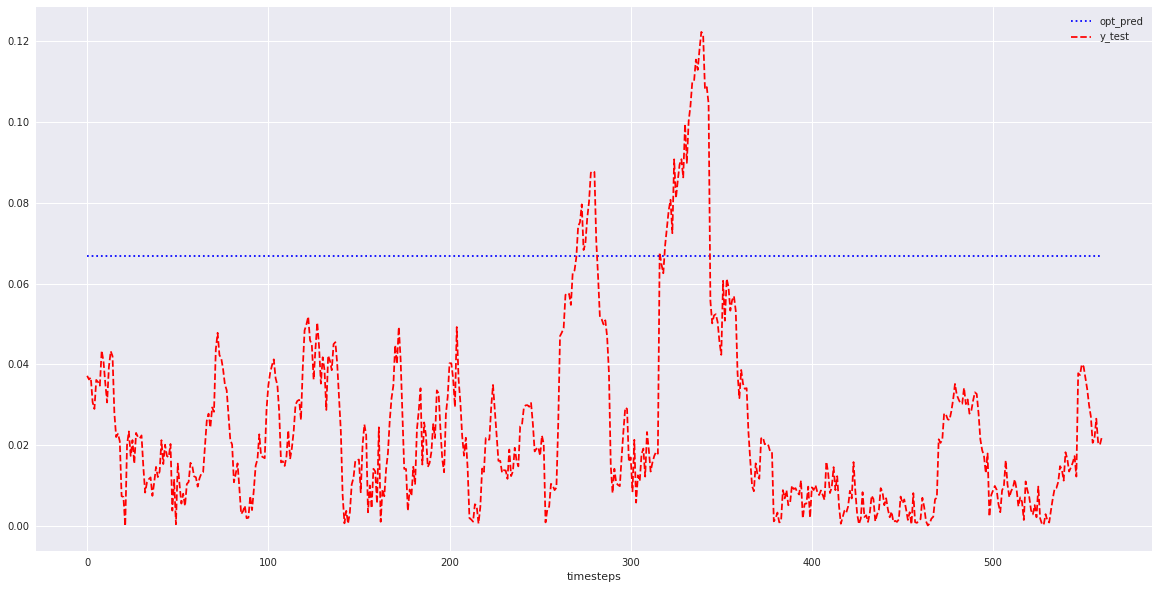

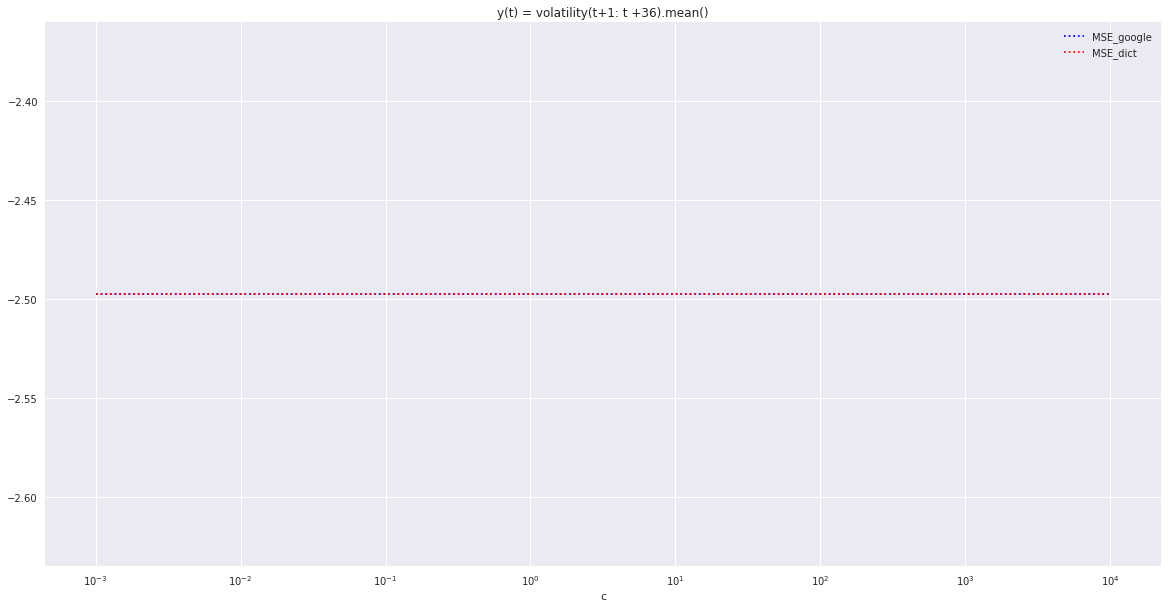


1 50 ....................

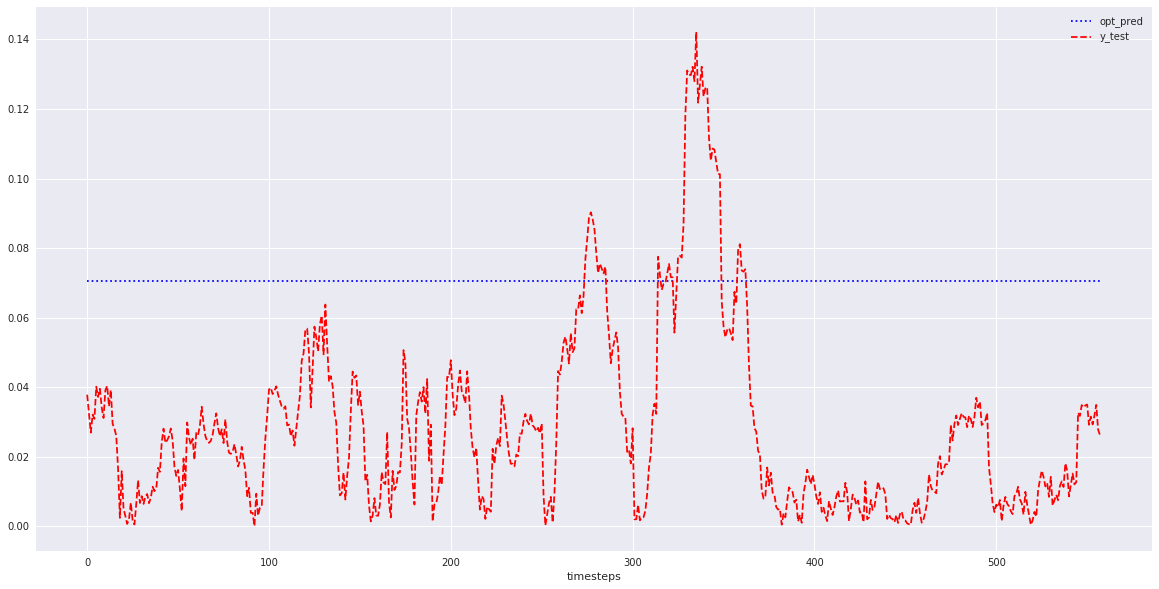

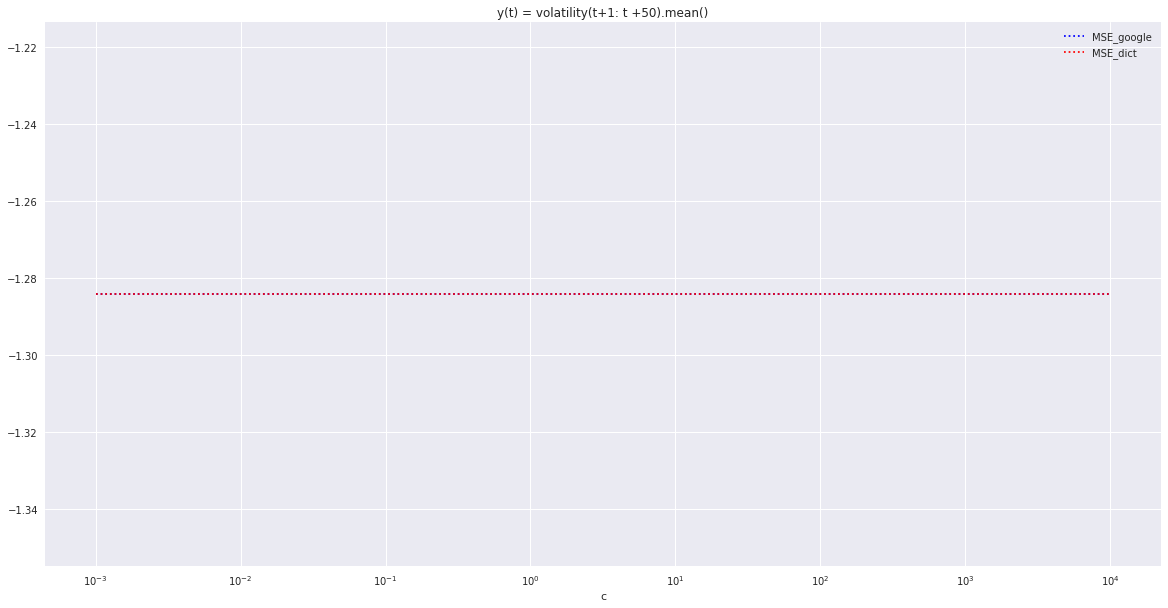

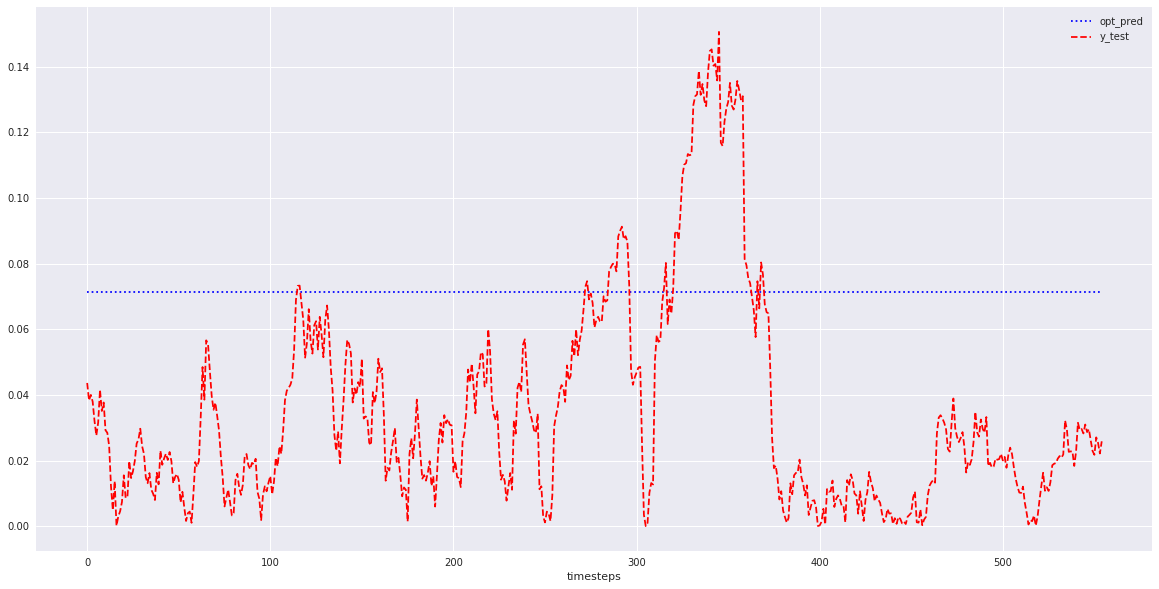

In [4]:
# ========== simple SVM Regression =================

#NORMALIZATION:
min_max_scaler = preprocessing.MinMaxScaler()
X_google = np.nan_to_num(np.asarray(X_google, dtype=float))
X_google = np.asarray(min_max_scaler.fit_transform(X_google))

X_dict = np.nan_to_num(np.asarray(X_dict, dtype=float))
X_dict = np.asarray(min_max_scaler.fit_transform(X_dict))

for (init, finish) in TREND_WINDOWs:
    print('\n'+str(init)+' '+str(finish)+' ', end='')

    x_google = list()
    x_dict = list()

    #CONSTRUCT LABELS
    y = list()
    for i in range(init,len(price)-finish):
        vol = abs(price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
        y.append(vol)
        x_google.append(X_google[i])
        x_dict.append(X_dict[i])


    y = np.array(y)
    x_google = np.array(x_google)
    x_dict = np.array(x_dict)


    MSEs_google = []
    MSEs_dict = []
    minMSE = float(np.inf)
    opt_pred = []
    opt_test = []
    for c in np.logspace(-3,4,10):
        for (x,y,MSEs) in [(x_google,y,MSEs_google),(x_dict,y,MSEs_dict)]:
            print('.', end='')
            
            #DATASET DIVISION:
            train=0.7
            nt=math.ceil(len(x)*train)
            x_tv = x[:nt]
            y_tv = y[:nt]
            x_test = x[nt:]
            y_test = y[nt:]

            #print('UP: '+str(up)+'\t DOWN: '+str(down))
            #print('UP TRAIN-VAL: '+str(sum(y_tv)/len(y_tv)*100)+'%')
            #print('UP TEST: '+str(sum(y_test)/len(y_test)*100)+'%')

            svm_model = svm.SVR(kernel='linear', C=c)
            svm_model.fit(x_tv,y_tv)
            y_pred = svm_model.predict(x_test)
            mse = svm_model.score(x_test,y_test)
            MSEs.append(mse)
            if(mse < minMSE):
                minMSE = mse
                opt_pred = y_pred
                opt_test = y_test

    plt.figure(figsize=(20,10))
    plt.semilogx(np.logspace(-3,4,10), MSEs_dict,':b', label='MSE_google')
    plt.semilogx(np.logspace(-3,4,10), MSEs_google,':r', label='MSE_dict')
    plt.xlabel('c')
    plt.title('y(t) = volatility(t'+'{0:+}'.format(init)+': t '+'{0:+}'.format(finish)+').mean()')
    plt.legend()
    #plt.savefig('volatilityPredictions/SVM/Regression_trend_('+str(init)+','+str(finish)+').jpg')
    plt.show()
    plt.figure(figsize=(20,10))
    plt.plot(opt_pred,':b', label='opt_pred')
    plt.plot(opt_test,'--r', label='y_test')
    plt.xlabel('timesteps')
    plt.legend()


-48 0 
-35 0 
-28 0 
-7 0 
-1 0 
1 2 
1 8 
1 29 
1 36 
1 50 

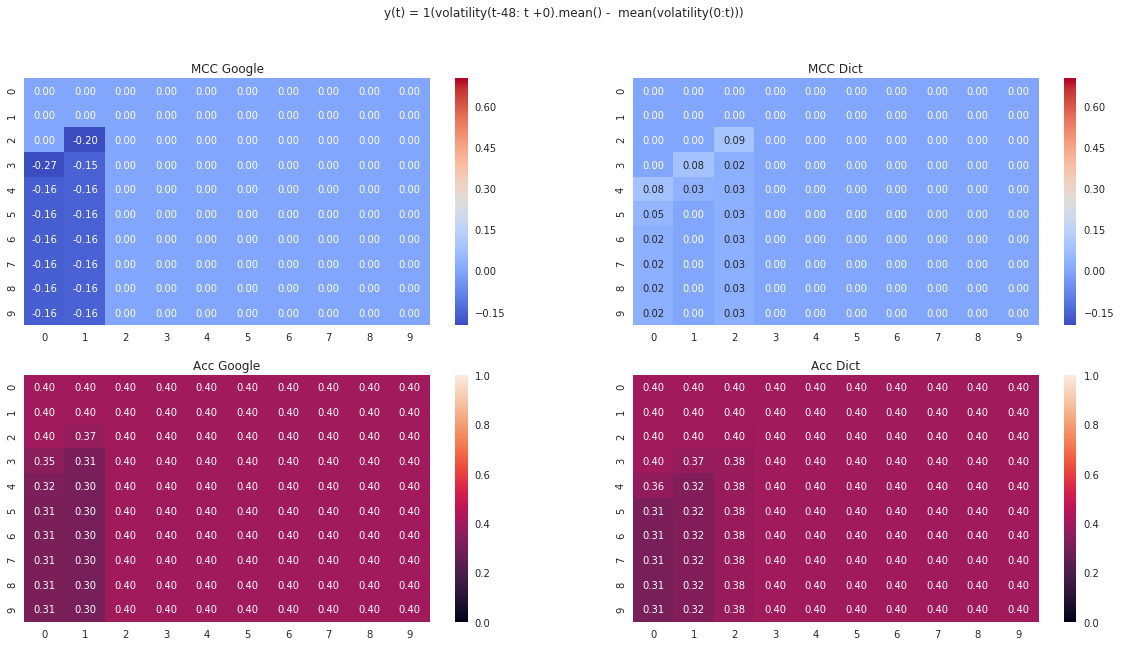

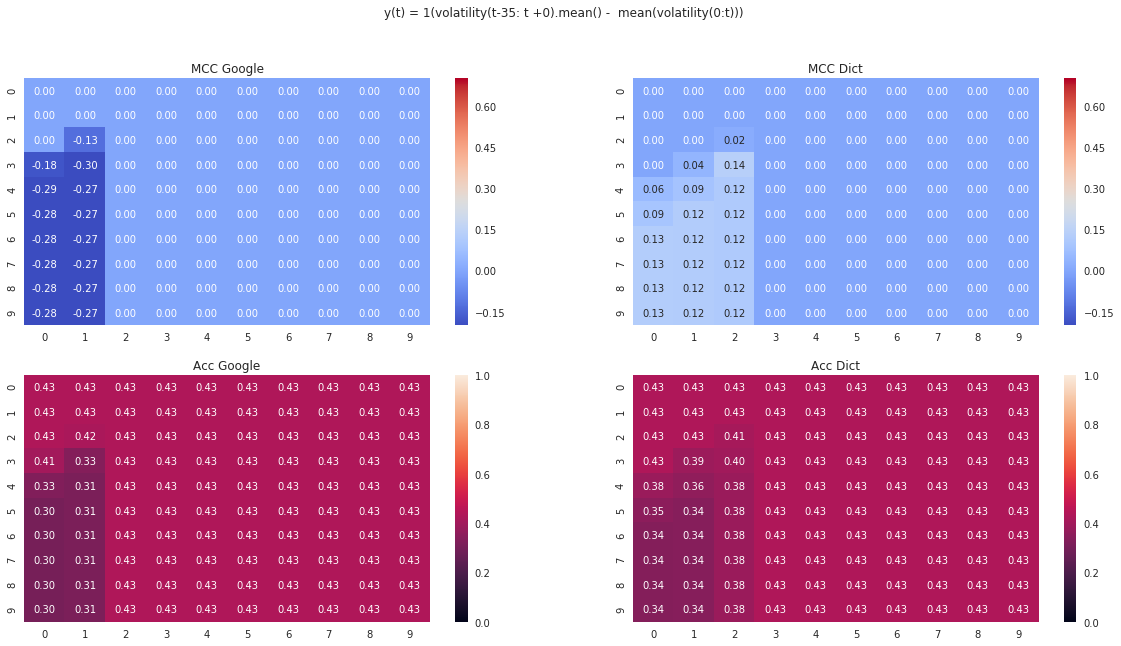

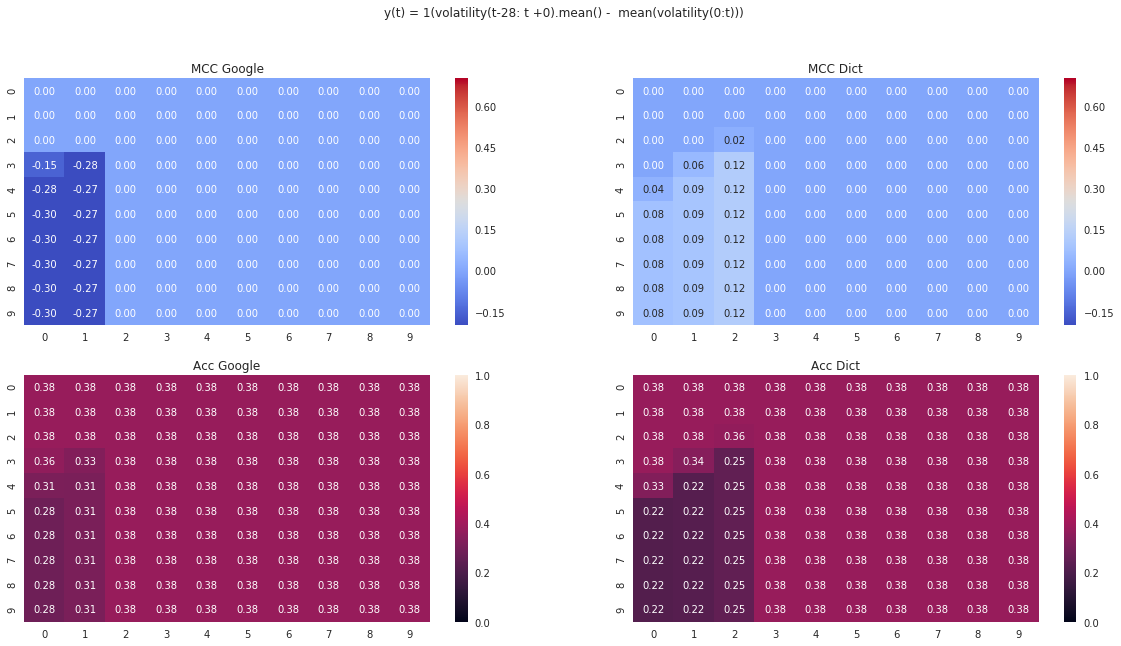

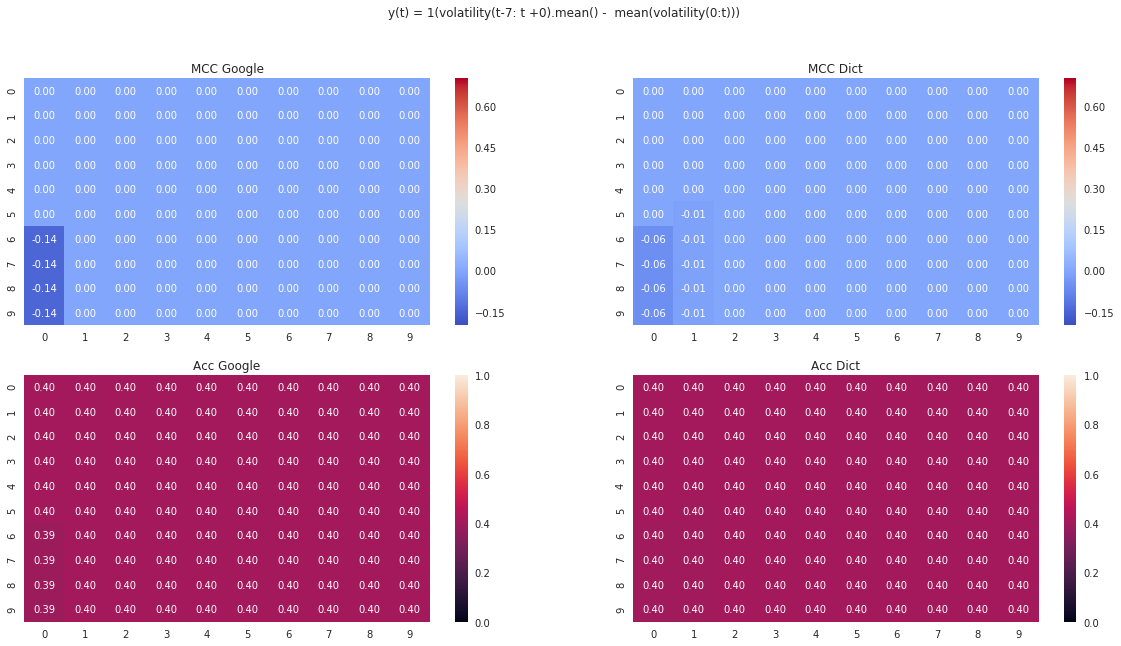

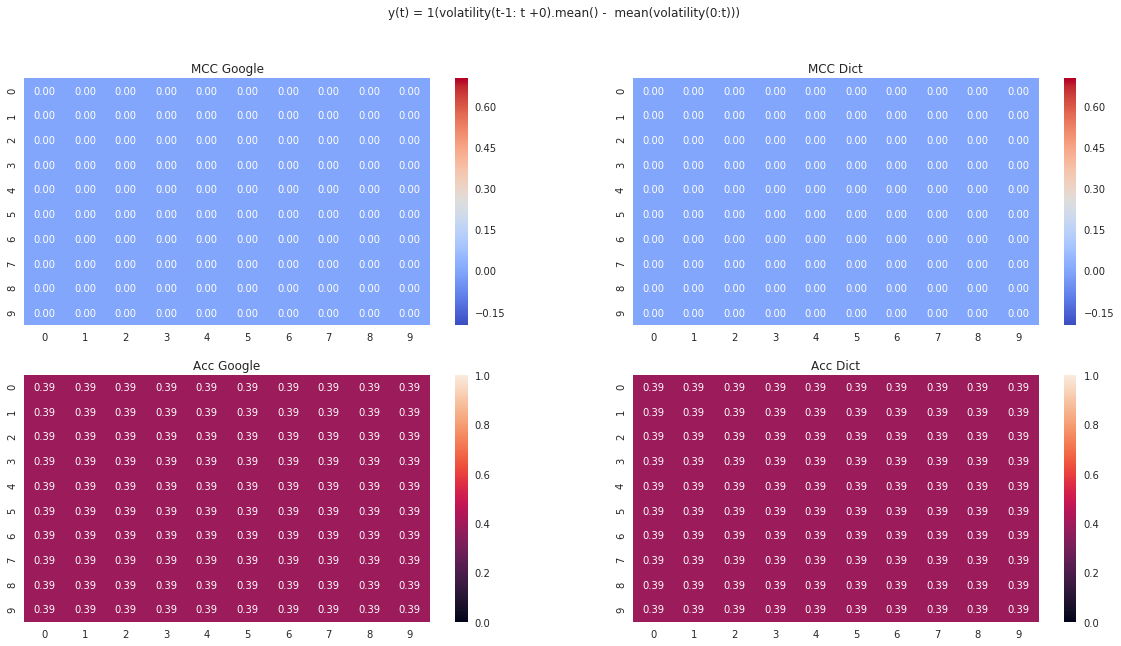

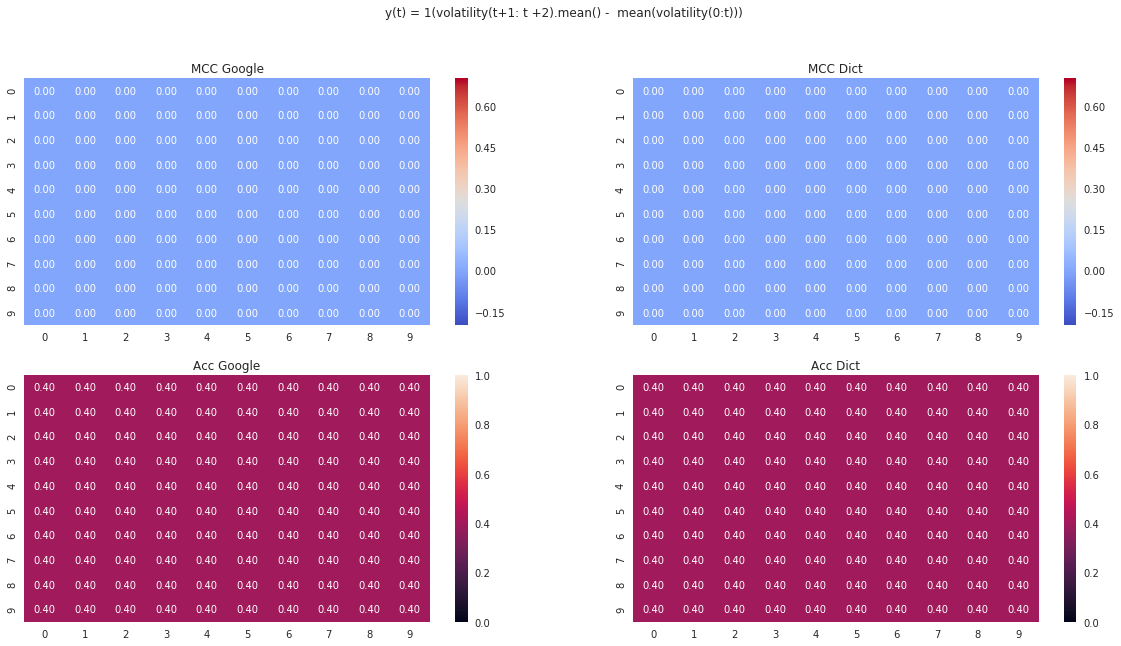

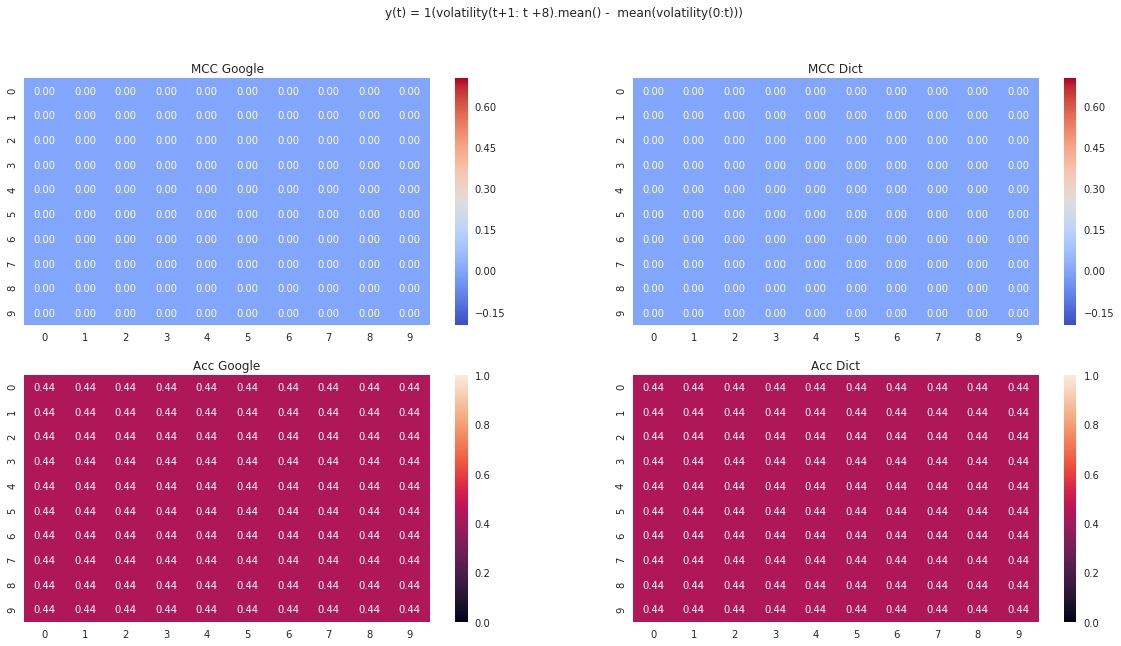

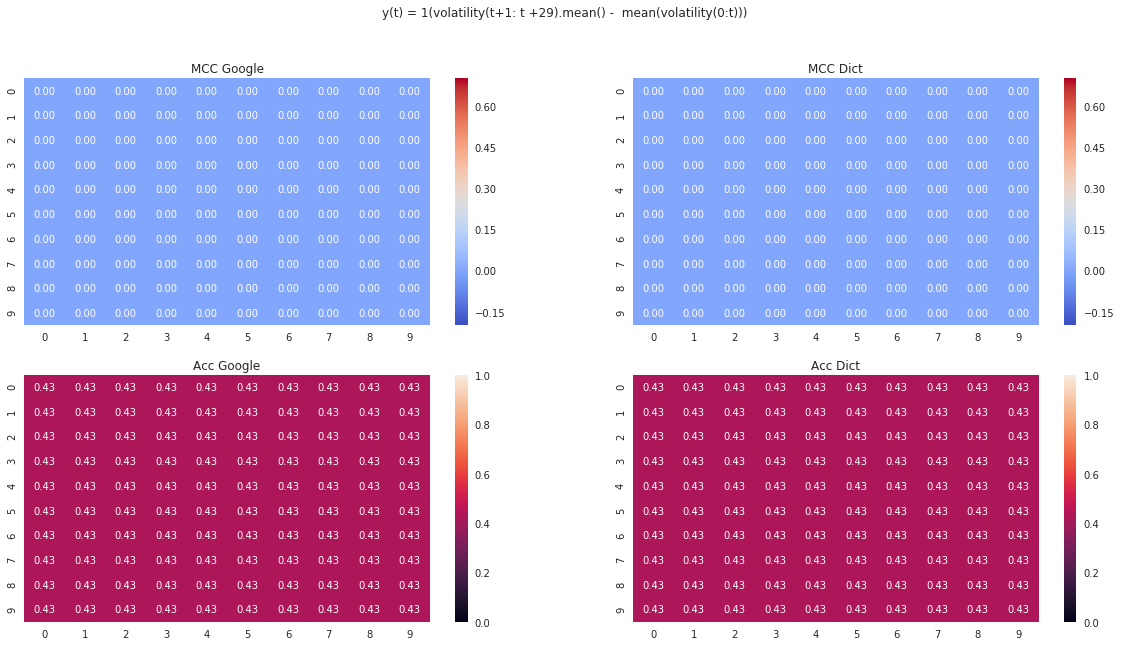

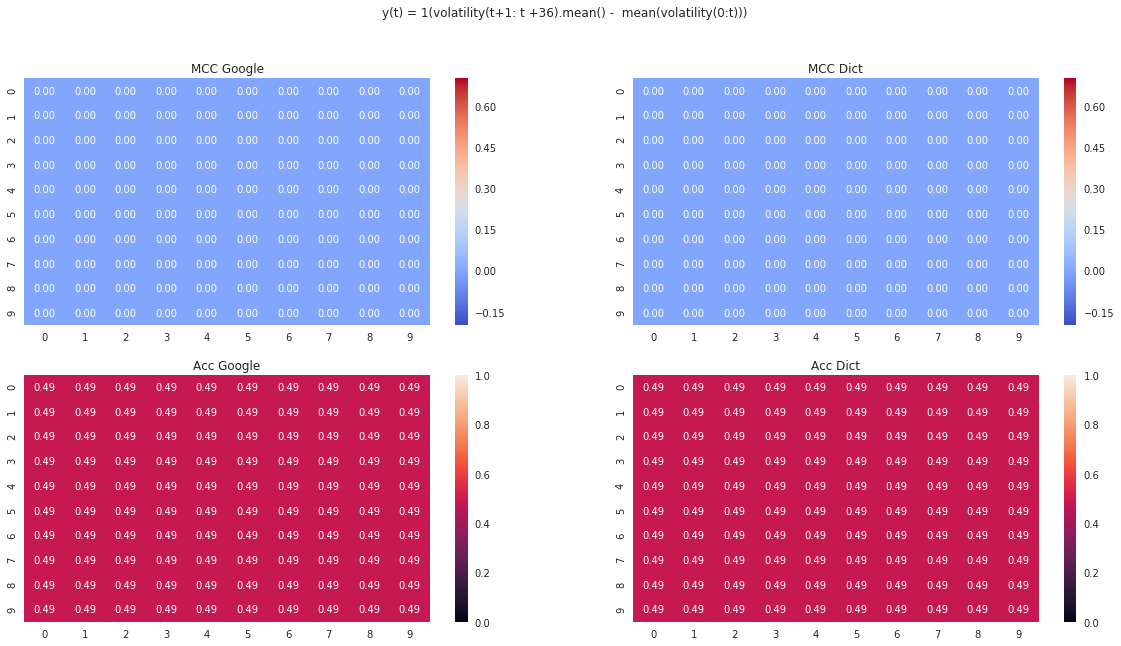

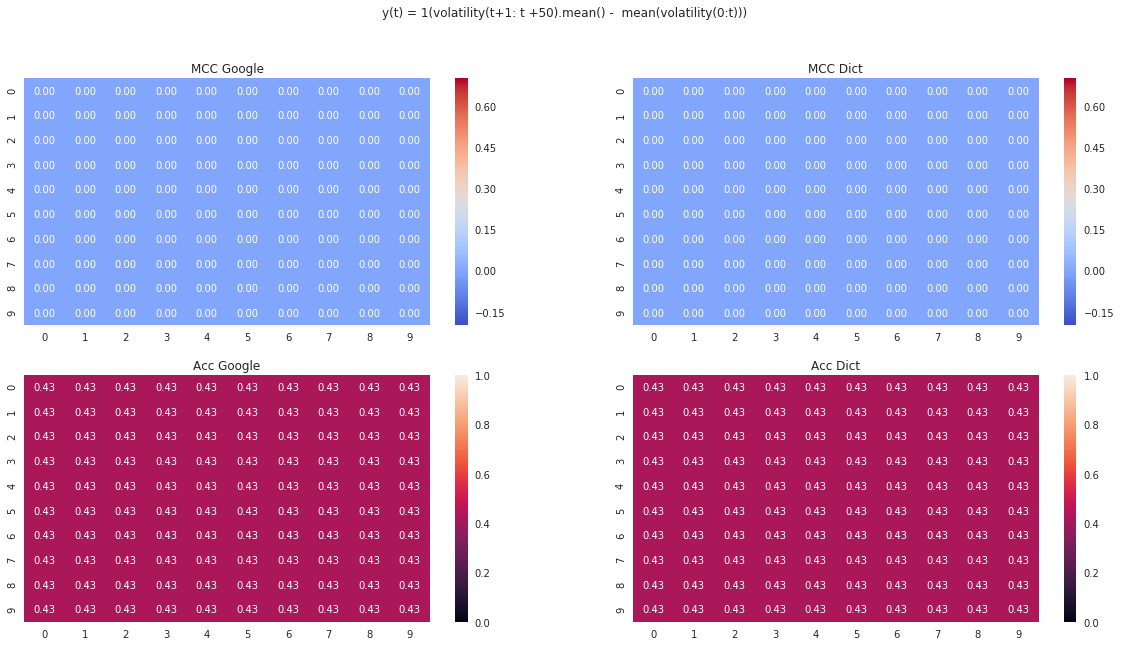

In [3]:
# ========== KSVM Regression =================




#NORMALIZATION:
min_max_scaler = preprocessing.MinMaxScaler()
X_google = np.nan_to_num(np.asarray(X_google, dtype=float))
X_google = np.asarray(min_max_scaler.fit_transform(X_google))

X_dict = np.nan_to_num(np.asarray(X_dict, dtype=float))
X_dict = np.asarray(min_max_scaler.fit_transform(X_dict))

for (init, finish) in TREND_WINDOWs:
    print('\n'+str(init)+' '+str(finish)+' ', end='')

    x_google = list()
    x_dict = list()

    #CONSTRUCT LABELS
    y = list()
    runningMean = 0
    num = 0
    for i in range(init,len(price)-finish):
        vol = abs(price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
        runningMean += vol
        num += 1
        y.append(vol - (runningMean/num))
        x_google.append(X_google[i])
        x_dict.append(X_dict[i])

    y = np.array(y)
    x_google = np.array(x_google)
    x_dict = np.array(x_dict)


    accs_google = np.ones([10,10])*-1
    accs_dict = np.ones([10,10])*-1
    MCC_google = np.ones([10,10])*-1
    MCC_dict = np.ones([10,10])*-1
    cSpace = np.logspace(-3,4,10)
    gSpace = np.logspace(-3,4,10)
    for c in range(0,10):
        for g in range(0,10):
            for (x,y,MCCs,accs) in [(x_google,y,MCC_google,accs_google),(x_dict, y,MCC_dict,accs_dict)]:
                #DATASET DIVISION:
                train=0.7
                nt=math.ceil(len(x)*train)
                x_tv = x[:nt]
                y_tv = y[:nt]
                x_test = x[nt:]
                y_test = y[nt:]

                #print('UP: '+str(up)+'\t DOWN: '+str(down))
                #print('UP TRAIN-VAL: '+str(sum(y_tv)/len(y_tv)*100)+'%')
                #print('UP TEST: '+str(sum(y_test)/len(y_test)*100)+'%')

                svm_model = svm.SVR(kernel='rbf', C=cSpace[c], gamma=gSpace[g])
                svm_model.fit(x_tv,y_tv)
                y_pred = svm_model.predict(x_test)
                y_test_binary = [1 if label>0 else 0 for label in y_test]
                y_pred_binary = [1 if guess>0 else 0 for guess in y_pred]
                acc = sum([1 if y_test_binary[i]*y_pred_binary[i] >0 else 0 for i in range(len(y_pred))])/len(y_pred)
                confmatrix = confusion_matrix(y_test_binary, y_pred_binary)
                tn, fp, fn, tp = confmatrix.ravel()
                denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                accs[c][g] = acc
                MCCs[c][g] = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
        #       print('MCC,score',MCC)
        #       print('Acc-score:',acc)
        #       print('Window:',TREND_WINDOW)
        #       print(confmatrix)
        #       plt.plot(y_pred)
        #       plt.plot(y_test)
        #       plt.show()
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,10))
    fig.suptitle('y(t) = 1(volatility(t'+'{0:+}'.format(init)+': t '+'{0:+}'.format(finish)+').mean() -  mean(volatility(0:t)))')
    ax1.set_title('MCC Google')
    sns_plot = sns.heatmap(MCC_google, ax=ax1, vmin=-0.2, vmax=0.7, annot=True, fmt=".2f",cmap='coolwarm')
    ax2.set_title('MCC Dict')
    sns_plot = sns.heatmap(MCC_dict,ax=ax2, vmin=-0.2, vmax=0.7, annot=True, fmt=".2f",cmap='coolwarm')
    
    ax3.set_title('Acc Google')
    sns_plot = sns.heatmap(accs_google, ax=ax3, vmin=0, vmax=1, annot=True, fmt=".2f")
    ax4.set_title('Acc Dict')
    sns_plot = sns.heatmap(accs_dict,ax=ax4, vmin=0, vmax=1, annot=True, fmt=".2f")
    plt.savefig('volatilityPredictions/KSVM/Regression_trend_('+str(init)+','+str(finish)+').jpg')


In [ ]:
np.asarray(x_dict)[:,7]